In [38]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Multiagent Simulation    

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')

from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import random
import torch

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from rl_env.waymax_env import MultiAgentEnvironment
from rl_env.waymax_util import WomdLoader
max_num_objects = 32
from rl_env.sim_agent_actor import SimAgentMTR

from mtr.config import cfg, cfg_from_yaml_file
cfg = cfg_from_yaml_file(
    # 'tools/cfgs/waymo/rl_finetune.yaml',
    'tools/cfgs/waymo/bc_atten_ctrl.yaml',
    cfg)

# Import model
from mtr.models.context_encoder.mtr_encoder import MTREncoder

from mtr.models.motion_decoder.bc_decoder import BCDecoder
dynamics_model = dynamics.InvertibleBicycleModel(max_accel=10, max_steering=0.6)
path = 'output/bc_ctrl_1_freeze/epoch=0-step=175000.ckpt'

# from mtr.models.motion_decoder.bc_decoder_original import BCDecoder
# dynamics_model = dynamics.DeltaLocal()
# path = 'output/bc_atten_4_unfreeze_state/epoch=19-step=1211340.ckpt'

import matplotlib.pyplot as plt


# Define Environment

In [40]:
# create a dataset
WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=max_num_objects,
    shuffle_seed = 0,
)

data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)


# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.



# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = init_steps,
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.MODELED,
        rewards = _config.LinearCombinationRewardConfig(
            rewards={
                'overlap': 1.0, # Positive is good.  
                'offroad': 1.0, # Negative is good.
                'kinematics': 1.0, # Negative is good.
            }
        )
    ),
)


# Define Control Policy

In [41]:
@jax.jit
def check_controlled(state: datatypes.SimulatorState):
    current_stamp = state.timestep
    # is_valid = jnp.logical_or(state.object_metadata.is_modeled, state.object_metadata.is_sdc)
    is_valid = state.sim_trajectory.valid[..., current_stamp]
    
    # get velocity in the log
    v_x_log = state.log_trajectory.vel_x # [num_agents, num_steps]
    v_y_log = state.log_trajectory.vel_y # [num_agents, num_steps]
    valid_log = state.log_trajectory.valid
    v_x_log = jnp.where(valid_log, v_x_log, 0)
    v_y_log = jnp.where(valid_log, v_y_log, 0)
    v_log = jnp.linalg.norm(jnp.stack([v_x_log, v_y_log], axis=-1), axis=-1)
    v_max = jnp.max(v_log, axis=-1)
    is_moving = v_max > 0.1
    
    is_vehicle = (state.object_metadata.object_types == 1)
    
    return jnp.logical_and(is_valid, jnp.logical_and(is_moving, is_vehicle))

# @jax.jit
# def check_controlled(state: datatypes.SimulatorState):
#     return state.object_metadata.is_modeled

In [42]:
# Setup a few actors, see visualization below for how each actor behaves.

# An actor that doesn't move, controlling all objects with index > 4
obj_idx = jnp.arange(max_num_objects)
actor_gt = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: ~check_controlled(state),
)

encoder = MTREncoder(cfg.MODEL.CONTEXT_ENCODER)
decoder = BCDecoder(encoder.num_out_channels, cfg.MODEL.MOTION_DECODER)
# load model
state_dict = torch.load(path)['state_dict']

encoder.load_model(state_dict)
decoder.load_model(state_dict)

actor_policy = SimAgentMTR(
    context_encoder= encoder,
    motion_decoder= decoder,
    is_controlled_func = check_controlled,
)

actor_policy.eval()
actor_policy.to('cuda')

actors = [actor_policy, actor_gt]

jit_select_action_list = [actor.select_action for actor in actors]

""

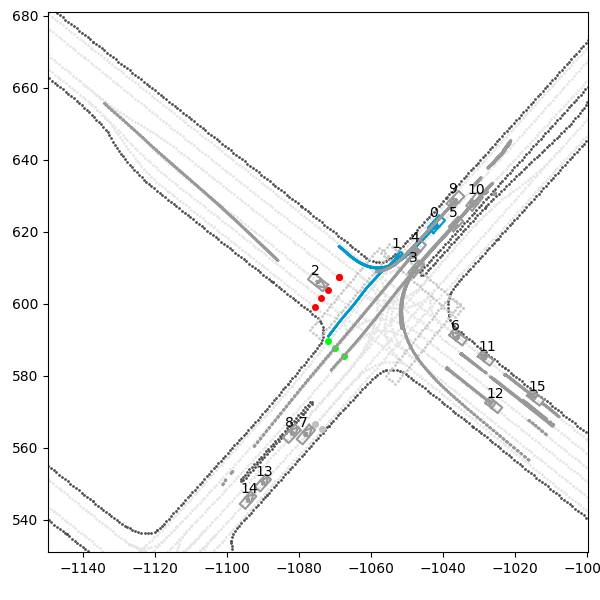

(Array([0, 1], dtype=int32),)


In [51]:
scenario_id, scenario = data_iter.next()
scenario : datatypes.SimulatorState
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))

In [44]:
from rl_env.env_utils import compute_inverse
from waymax.agents import actor_core

In [52]:
# get a scenario from the dataset
# scenario : datatypes.SimulatorState = next(data_iter)
states = [env.reset(scenario)]
a = np.zeros((32,90, 2))
for i in range(states[0].remaining_timesteps):
  current_state = states[-1]
  
  policy_output, _, _, _ = actor_policy.select_action({}, current_state, None, None)
  # gt = compute_inverse(current_state.log_trajectory,
  #                     current_state.timestep,
  #                     0.1,
  #                     False)

  # policy_output = actor_core.WaymaxActorOutput(
  #           action=gt,
  #           actor_state=None,
  #           is_controlled=check_controlled(current_state),
  #       )

  a[:, i] = np.asarray(policy_output.action.data)
  next_state = env.step_sim_agent(states[-1], [policy_output])
  states.append(next_state)

idx =jnp.where(policy_output.is_controlled)[0]
print("Sim Agent Ids:", jnp.where(policy_output.is_controlled))

Sim Agent Ids: (Array([ 0,  3,  4,  5,  6,  8,  9, 10, 11, 12, 15, 16, 17, 18, 20, 22, 24,
       26, 29, 30, 31], dtype=int32),)


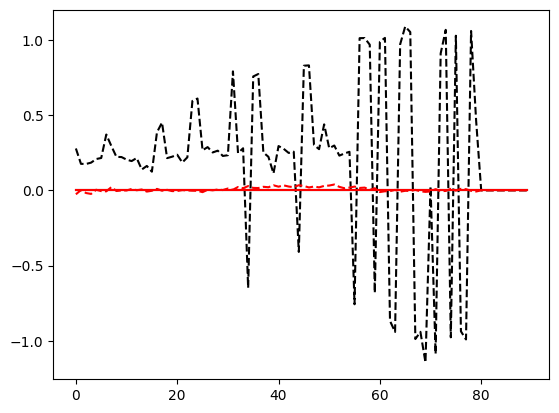

In [53]:
plt.plot(a[0, :, 0]/10, '--k')
plt.plot(a[0, :, 1]/0.3, '--r')
plt.plot(a[1, :, 0]/10, '-k')
plt.plot(a[1, :, 1]/0.3, '-r')

In [54]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.MODELED))
mediapy.show_video(imgs, fps=10)